In [86]:
# For training model
import torch
import torch.nn as nn
import torch.optim as optim
import torch.utils.data
import torch.nn.functional as F
from torch.utils.data import TensorDataset, DataLoader
from torch.optim.lr_scheduler import ExponentialLR
# For utilities
import numpy as np
import networkx as nx
import math
import json
import pickle
import time
import ast
import matplotlib.pyplot as plt
from einops import rearrange

In [87]:
# Load proxy score data from json file
file_path = r'/home/ansonhon/mase_project/machop/naslib/data/zc_nasbench201.json'
with open(file_path, 'r') as file:
    data = json.load(file)

In [88]:
data_cifar10 = data['cifar10']
data_key_list = list(data_cifar10.keys())
data_cifar10[data_key_list[0]]

{'id': 0,
 'epe_nas': {'score': 1283.2991078420093, 'time': 1.51356539176777},
 'fisher': {'score': 0.036440409719944, 'time': 1.5310247791931033},
 'flops': {'score': 19.248832, 'time': 0.5273589231073856},
 'grad_norm': {'score': 10.883214950561523, 'time': 1.530008438974619},
 'grasp': {'score': 0.2447352409362793, 'time': 3.459309575147927},
 'jacov': {'score': -88.28987084337544, 'time': 1.5204479838721454},
 'l2_norm': {'score': 130.2005157470703, 'time': 0.3916725479066372},
 'nwot': {'score': 754.6843327648469, 'time': 1.217158482875675},
 'params': {'score': 0.129306, 'time': 0.5253524649888277},
 'plain': {'score': 0.03387480974197388, 'time': 1.509419356007129},
 'snip': {'score': 22.92317771911621, 'time': 1.416432005353272},
 'synflow': {'score': 44.48481149764257, 'time': 0.7747132447548211},
 'zen': {'score': 63.38789367675781, 'time': 1.422978401184082},
 'val_accuracy': 84.99}

In [89]:
# Parepare data into numpy type
val_accuracies = []
proxy_scores = {}
# name_list = ['epe_nas', 'fisher', 'flops', 'grad_norm', 'grasp', 'jacov', 'l2_norm', 'nwot', 'params', 'plain', 'snip', 'synflow', 'zen']
name_list = ['epe_nas', 'fisher', 'flops', 'grad_norm', 'grasp', 'jacov', 'l2_norm', 'params', 'plain', 'snip', 'synflow', 'zen']

for name in name_list:
    proxy_scores[name] = []

In [90]:
for key in data_key_list:
    temp = data_cifar10[key]
    # get accuracies
    accuracy = temp['val_accuracy']
    val_accuracies.append(accuracy)

    # get scores for each proxy
    for name in name_list:
        score = temp[name]['score']
        proxy_scores[name].append(score)

In [91]:
### Convert to numpy array
for name in name_list:
    proxy_scores[name] = np.array(proxy_scores[name])
    val_accuracies = np.array(val_accuracies)

In [92]:
### Normalize the data
for name in name_list:
    arr = proxy_scores[name]
    mean = np.mean(arr)
    stdd = np.std(arr)
    arr = (arr - mean) / stdd
    proxy_scores[name] = arr

val_accuracies /= 100

In [93]:
### Stack the scores into one big array
temp_arr = []
for key in proxy_scores:
    temp_arr.append(proxy_scores[key])

input_np = np.stack(temp_arr, axis = 1)
target_np = np.array(val_accuracies)

In [94]:
class NeuralModel(nn.Module):
    def __init__(self, input_size):
        super(NeuralModel, self).__init__()
        self.linear1 = nn.Linear(input_size, 64)
        self.sigmoid = nn.Sigmoid()
        self.linear2 = nn.Linear(64, 128)
        self.relu = nn.ReLU()
        self.linear3 = nn.Linear(128, 1)

    def forward(self, x):
        x = self.relu(self.linear1(x))
        x = self.relu(self.linear2(x))
        x = self.sigmoid(self.linear3(x))
        return x

In [95]:
# Convert data and target to tensor
data_tensor = torch.tensor(input_np, dtype=torch.float32)
target_tensor = torch.tensor(target_np, dtype=torch.float32)

In [96]:
# Split data into train and test sets
test_size = int(0.1 * len(data_tensor))  # 10% of the data for testing
indices = np.arange(len(data_tensor))
np.random.shuffle(indices)
train_indices, test_indices = indices[test_size:], indices[:test_size]

data_train, data_test = data_tensor[train_indices], data_tensor[test_indices]
target_train, target_test = target_tensor[train_indices], target_tensor[test_indices]

target_train

tensor([0.8806, 0.8900, 0.8913,  ..., 0.7596, 0.8770, 0.8872])

In [97]:
# Define hyperparameters
input_size = 12  # Dimension of the data
initial_learning_rate = 0.0001
batch_size = 16
num_epochs = 50
gamma = 1

# Create DataLoader for training and testing sets
train_dataset = TensorDataset(data_train, target_train)
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

test_dataset = TensorDataset(data_test, target_test)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

# Initialize the model
model = NeuralModel(input_size)

# Define loss function and optimizer
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=initial_learning_rate)
scheduler = ExponentialLR(optimizer, gamma=gamma)

# Training loop
test_losses = []
for epoch in range(num_epochs):
    model.train()  # Set model to training mode
    for inputs, targets in train_loader:
        # Forward pass
        outputs = model(inputs)
        # Compute loss
        loss = criterion(outputs, targets)
        # print("outputs:", inputs)
        # print("targets: ", targets)
        # Backward pass and optimization
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    # apply decay to learning rate
    scheduler.step()
    # Print progress
    print(f'Epoch [{epoch+1}/{num_epochs}], Train Loss: {loss.item():.4f}')

    # Evaluation on test set
    model.eval()  # Set model to evaluation mode
    test_loss = 0.0
    with torch.no_grad():
        for inputs, targets in test_loader:
            outputs = model(inputs)
            test_loss += criterion(outputs, targets).item()
        test_losses.append(test_loss/len(test_loader))

print(f'Test Loss: {test_loss / len(test_loader):.4f}')

/home/ansonhon/miniconda3/envs/mase/lib/python3.10/site-packages/torch/nn/modules/loss.py:535: UserWarning: Using a target size (torch.Size([16])) that is different to the input size (torch.Size([16, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


/home/ansonhon/miniconda3/envs/mase/lib/python3.10/site-packages/torch/nn/modules/loss.py:535: UserWarning: Using a target size (torch.Size([15])) that is different to the input size (torch.Size([15, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/home/ansonhon/miniconda3/envs/mase/lib/python3.10/site-packages/torch/nn/modules/loss.py:535: UserWarning: Using a target size (torch.Size([10])) that is different to the input size (torch.Size([10, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Epoch [1/50], Train Loss: 0.0038
Epoch [2/50], Train Loss: 0.0057
Epoch [3/50], Train Loss: 0.0384
Epoch [4/50], Train Loss: 0.0073
Epoch [5/50], Train Loss: 0.0038
Epoch [6/50], Train Loss: 0.0072
Epoch [7/50], Train Loss: 0.0056
Epoch [8/50], Train Loss: 0.0378
Epoch [9/50], Train Loss: 0.0378
Epoch [10/50], Train Loss: 0.0033
Epoch [11/50], Train Loss: 0.0070
Epoch [12/50], Train Loss: 0.0022
Epoch [13/50], Train Loss: 0.0409
Epoch [14/50], Train Loss: 0.0420
Epoch [15/50], Train Loss: 0.0017
Epoch [16/50], Train Loss: 0.0046
Epoch [17/50], Train Loss: 0.0019
Epoch [18/50], Train Loss: 0.0052
Epoch [19/50], Train Loss: 0.0022
Epoch [20/50], Train Loss: 0.0019
Epoch [21/50], Train Loss: 0.0198
Epoch [22/50], Train Loss: 0.0396
Epoch [23/50], Train Loss: 0.0396
Epoch [24/50], Train Loss: 0.0531
Epoch [25/50], Train Loss: 0.0382
Epoch [26/50], Train Loss: 0.0397
Epoch [27/50], Train Loss: 0.0031
Epoch [28/50], Train Loss: 0.0024
Epoch [29/50], Train Loss: 0.0036
Epoch [30/50], Train Lo

In [98]:
# File path where you want to save the model
file_path = "/home/ansonhon/mase_project/nas_results/meta_proxy_cifar10.pt"

# Save the trained model
torch.save(model.state_dict(), file_path)

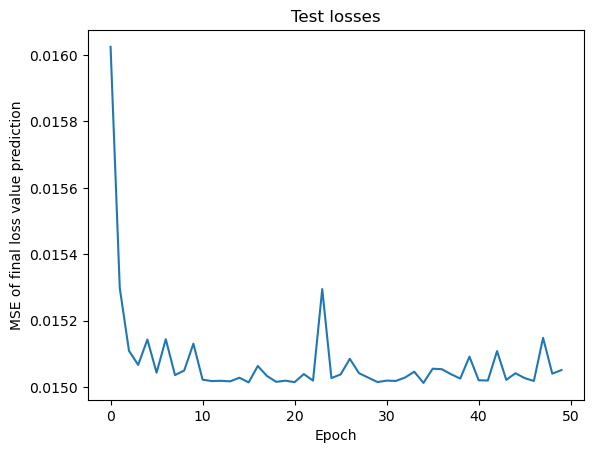

In [99]:
plt.plot(test_losses)
plt.title('Test losses')
plt.xlabel('Epoch')
plt.ylabel('MSE of final loss value prediction')
plt.show()

In [100]:
model.eval()
inputs_list = []
targets_list = []
predictions = []
with torch.no_grad():
    for inputs, target in test_loader:
        outputs = model(inputs)
        inputs_list.append(inputs)
        predictions.append(outputs)
        targets_list.append(target)

In [107]:
print(predictions)

[tensor([[0.8299],
        [0.8323],
        [0.8292],
        [0.8298],
        [0.8327],
        [0.8372],
        [0.8450],
        [0.8325],
        [0.8313],
        [0.8283],
        [0.8332],
        [0.8338],
        [0.8321],
        [0.8337],
        [0.8320],
        [0.8335]]), tensor([[0.8333],
        [0.8344],
        [0.8323],
        [0.8205],
        [0.8318],
        [0.8338],
        [0.8333],
        [0.8028],
        [0.8309],
        [0.8337],
        [0.8368],
        [0.8318],
        [0.8384],
        [0.8324],
        [0.8343],
        [0.8256]]), tensor([[0.8345],
        [0.8305],
        [0.8335],
        [0.8326],
        [0.8309],
        [0.8340],
        [0.8327],
        [0.8346],
        [0.8300],
        [0.8341],
        [0.8305],
        [0.8370],
        [0.8319],
        [0.8292],
        [0.8300],
        [0.8317]]), tensor([[0.8274],
        [0.8303],
        [0.8358],
        [0.8368],
        [0.8323],
        [0.8342],
        [0.8322],
   

In [102]:
concat_predictions = torch.cat(predictions, dim = 0)
predictions_np = concat_predictions.numpy()

concat_inputs = torch.cat(inputs_list, dim = 0)
inputs_np = concat_inputs.numpy()

concat_targets = torch.cat(targets_list, dim = 0)
targets_np = concat_targets.numpy()

In [103]:
targets_np = rearrange(targets_np, 'a -> a 1')

In [104]:
corr_to_plot  = np.hstack((inputs_np, predictions_np, targets_np))

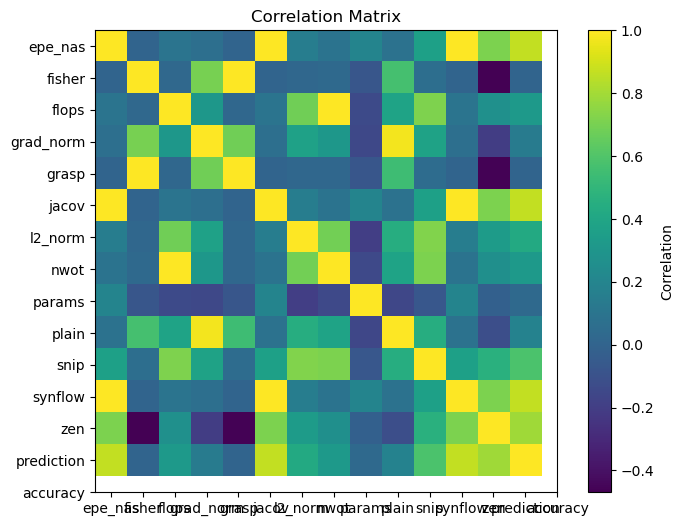

In [105]:
correlation_matrix = np.corrcoef(corr_to_plot, rowvar=False)
# Plot correlation matrix
plt.figure(figsize=(8, 6))
plt.imshow(correlation_matrix, cmap='viridis', interpolation='nearest')
plt.colorbar(label='Correlation')
plt.title('Correlation Matrix')
plt.xticks(np.arange(15),['epe_nas', 'fisher', 'flops', 'grad_norm', 'grasp', 'jacov', 'l2_norm', 'nwot', 'params', 'plain', 'snip', 'synflow', 'zen', 'prediction', 'accuracy'])
plt.yticks(np.arange(15),['epe_nas', 'fisher', 'flops', 'grad_norm', 'grasp', 'jacov', 'l2_norm', 'nwot', 'params', 'plain', 'snip', 'synflow', 'zen', 'prediction', 'accuracy'])
plt.show()

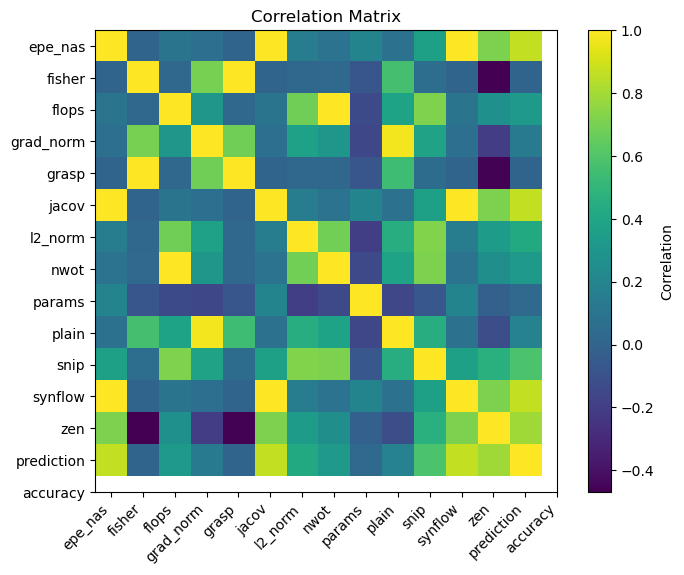

In [106]:
correlation_matrix = np.corrcoef(corr_to_plot, rowvar=False)

# Plot correlation matrix
plt.figure(figsize=(8, 6))
plt.imshow(correlation_matrix, cmap='viridis', interpolation='nearest')
plt.colorbar(label='Correlation')
plt.title('Correlation Matrix')

# Set x-axis labels with rotation
plt.xticks(np.arange(15), ['epe_nas', 'fisher', 'flops', 'grad_norm', 'grasp', 'jacov', 'l2_norm', 'nwot', 'params', 'plain', 'snip', 'synflow', 'zen', 'prediction', 'accuracy'], rotation=45, ha='right')

# Set y-axis labels without rotation
plt.yticks(np.arange(15), ['epe_nas', 'fisher', 'flops', 'grad_norm', 'grasp', 'jacov', 'l2_norm', 'nwot', 'params', 'plain', 'snip', 'synflow', 'zen', 'prediction', 'accuracy'])

plt.show()